--- Plotting Elliptical Orbit ---
Note: For hyperbolic orbit, true anomaly plotted from -128.7 to 128.7 degrees.


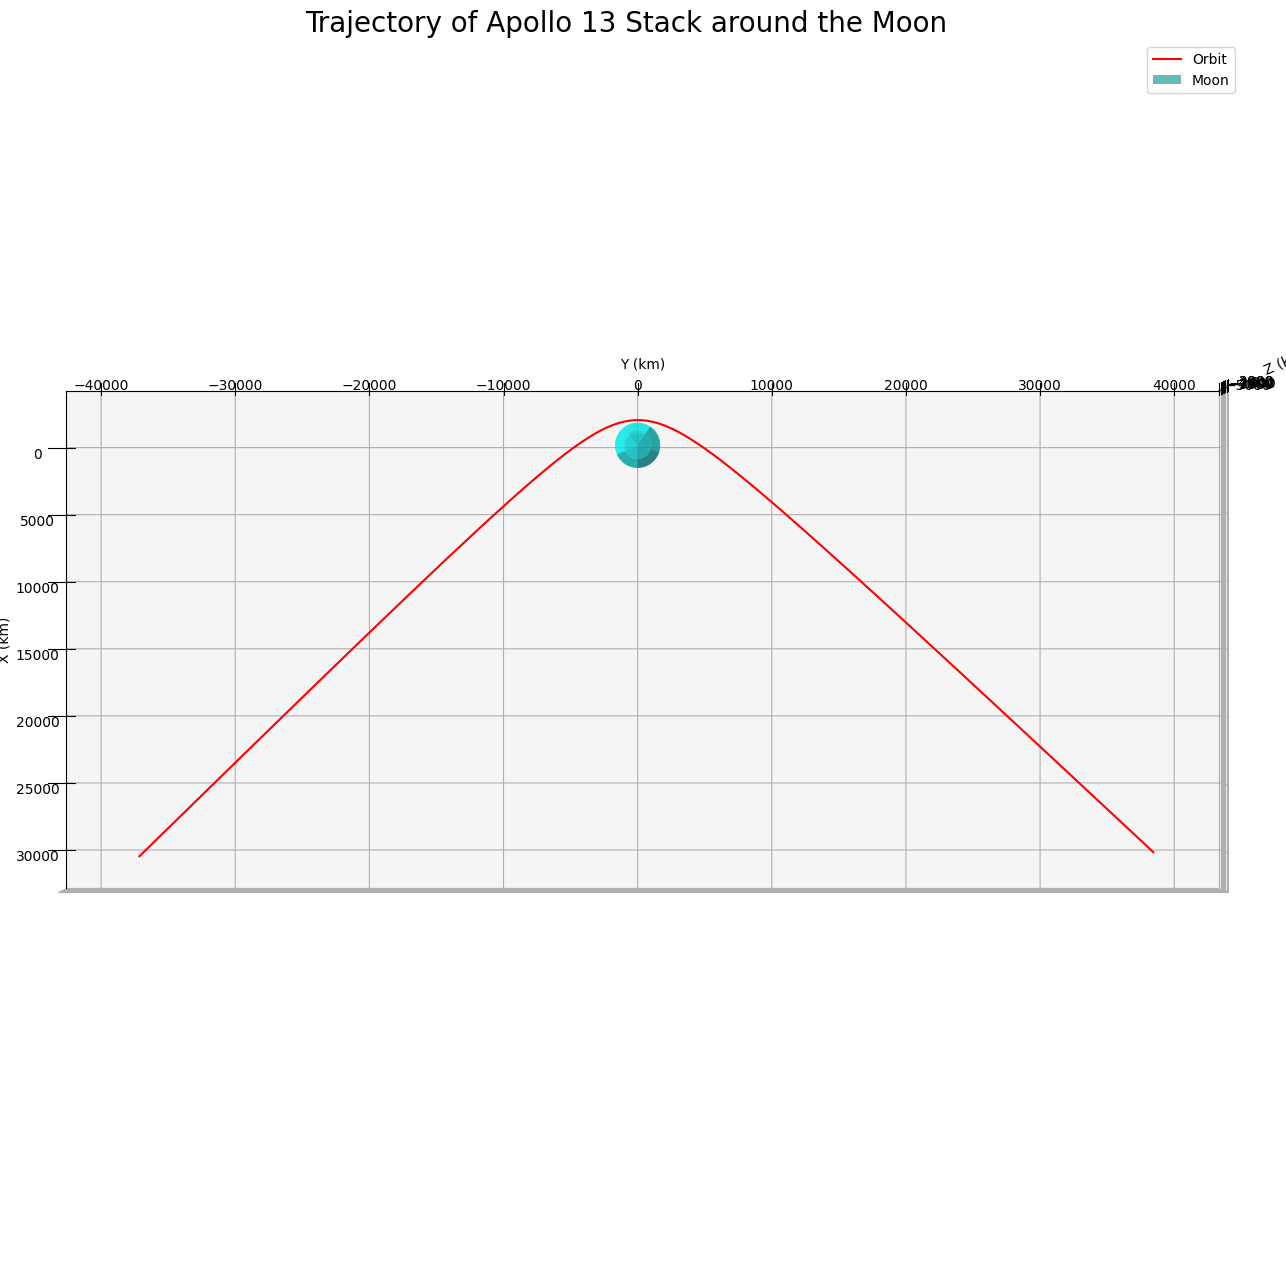

Maximum velocity: 2.53 km/s   8301.10 ft/s
Pericynthius: 136.02 km


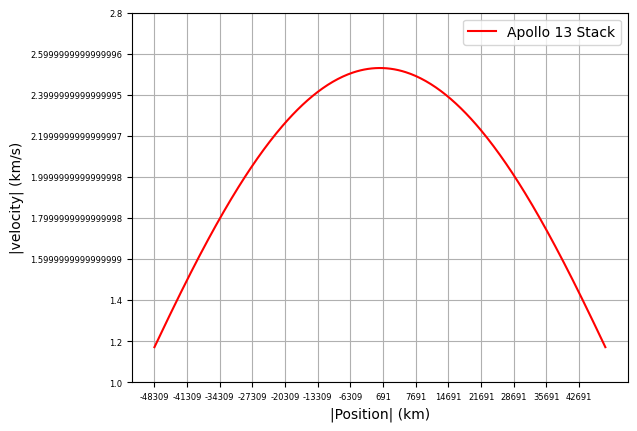

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from PIL.ImageOps import grayscale
from matplotlib import cm

# https://svs.gsfc.nasa.gov/4791/

# Gravitational parameter  (mu = GM)
MU_MOON = 4902.8  # km^3/s^2
R_MOON = 1737.4 # km

# keplerian_to_state_vectors function (included for self-containment)
# Adjusted to handle 'a' parameter for different orbit types.
def keplerian_to_state_vectors(a, e, i, raan, arg_of_periapsis, true_anomaly):
    """
    Converts Keplerian orbital elements to orbital state vectors (position and velocity).

    Args:
        a (float): Semi-major axis in kilometers. Positive for elliptical, negative for hyperbolic.
                   For parabolic (e=1), this parameter is internally treated as the periapsis radius
                   for calculating the semilatus rectum 'p'.
        e (float): Eccentricity (dimensionless).
        i (float): Inclination in degrees.
        raan (float): Right Ascension of the Ascending Node in degrees.
        arg_of_periapsis (float): Argument of Periapsis in degrees.
        true_anomaly (float): True Anomaly in degrees.
        mu (float): Gravitational parameter (GM) of the central body in km^3/s^2.

    Returns:
        tuple: A tuple containing:
               - r_vec (np.ndarray): Position vector [x, y, z] in kilometers.
               - v_vec (np.ndarray): Velocity vector [vx, vy, vz] in kilometers/second.
    """

    # Convert angles from degrees to radians
    i_rad = np.radians(i)
    raan_rad = np.radians(raan)
    arg_of_periapsis_rad = np.radians(arg_of_periapsis)
    true_anomaly_rad = np.radians(true_anomaly)
    mu = MU_MOON

    # Calculate semilatus rectum (p)
    # p = a * (1 - e**2) for elliptical and hyperbolic.
    # For parabolic (e=1), p = 2 * r_p, where 'a' is effectively r_p here.
    if abs(e - 1.0) < 1e-9: # Parabolic orbit (e is very close to 1)
        p = 2 * a # For parabolic, 'a' argument is used as periapsis_distance for 'p' calculation.
    else: # Elliptical or Hyperbolic
        p = a * (1 - e**2)

    # Handle cases where 'p' might be extremely small, indicating a degenerate orbit.
    if p < 1e-9 and not (abs(e - 1.0) < 1e-9):
        raise ValueError("Degenerate orbit: Semilatus rectum 'p' is too small for a non-parabolic orbit.")

    # Distance from focus to spacecraft (r_norm)
    # This formula (r = p / (1 + e * cos(nu))) is universal for all conic sections.
    r_norm = p / (1 + e * np.cos(true_anomaly_rad))

    # Position vector in perifocal frame (rp)
    rp_x = r_norm * np.cos(true_anomaly_rad)
    rp_y = r_norm * np.sin(true_anomaly_rad)
    rp_z = 0.0
    rp_vec = np.array([rp_x, rp_y, rp_z])

    # Velocity components in perifocal frame (vp)
    if e < 1e-9: # Circular orbit, simplified velocity
        vp_x = 0.0
        vp_y = np.sqrt(mu / r_norm)
    else: # Elliptical, Parabolic, or Hyperbolic using general formulas
        vp_x = -np.sqrt(mu / p) * e * np.sin(true_anomaly_rad)
        vp_y = np.sqrt(mu / p) * (1 + e * np.cos(true_anomaly_rad))

    vp_z = 0.0
    vp_vec = np.array([vp_x, vp_y, vp_z])

    # 2. Rotation Matrices to transform from perifocal to ECI (Earth-Centered Inertial) frame
    # Rotation around Z-axis by argument of periapsis (w)
    R_w = np.array([
        [np.cos(arg_of_periapsis_rad), -np.sin(arg_of_periapsis_rad), 0],
        [np.sin(arg_of_periapsis_rad), np.cos(arg_of_periapsis_rad), 0],
        [0, 0, 1]
    ])

    # Rotation around X-axis by inclination (i)
    R_i = np.array([
        [1, 0, 0],
        [0, np.cos(i_rad), -np.sin(i_rad)],
        [0, np.sin(i_rad), np.cos(i_rad)]
    ])

    # Rotation around Z-axis by RAAN (Omega)
    R_raan = np.array([
        [np.cos(raan_rad), -np.sin(raan_rad), 0],
        [np.sin(raan_rad), np.cos(raan_rad), 0],
        [0, 0, 1]
    ])

    # Combined rotation matrix: R = R_raan @ R_i @ R_w
    R = R_raan @ R_i @ R_w

    # 3. Transform position and velocity vectors to the ECI frame
    r_vec = R @ rp_vec
    v_vec = R @ vp_vec

    return r_vec, v_vec


def plot_orbit(eccentricity, inclination, arg_of_periapsis, periapsis_distance, raan=0.0, num_points=360):
    """
    Plots an orbit given its Keplerian elements, deriving the semi-major axis from periapsis distance.

    Args:
        eccentricity (float): Eccentricity (dimensionless).
        inclination (float): Inclination in degrees.
        arg_of_periapsis (float): Argument of Periapsis in degrees.
        periapsis_distance (float): Distance at periapsis in kilometers.
        raan (float): Right Ascension of the Ascending Node in degrees (default 0.0).
        mu (float): Gravitational parameter (GM) of the central body in km^3/s^2.
        num_points (int): Number of points to use for plotting the orbit.
        central_body_radius (float): Radius of the central body for visualization (e.g., Earth radius).
    """
    e = eccentricity
    i = inclination
    w = arg_of_periapsis
    rp = periapsis_distance # periapsis distance
    mu = MU_MOON
    central_body_radius = R_MOON

    # Calculate semi-major axis 'a_keplerian' based on orbit type and periapsis distance.
    # This 'a_keplerian' will be passed to keplerian_to_state_vectors.
    if e < 1.0: # Elliptical orbit
        a_keplerian = rp / (1 - e) # Semi-major axis 'a' is positive
        orbit_type = "Elliptical"
        # For elliptical orbits, plot the full 360 degrees
        true_anomalies_deg = np.linspace(0, 360, num_points)
    elif abs(e - 1.0) < 1e-9: # Parabolic orbit (e is very close to 1)
        a_keplerian = rp # For parabolic, 'a' parameter in keplerian_to_state_vectors will be treated as periapsis distance (rp) for 'p' calculation.
        orbit_type = "Parabolic"
        # For parabolic, plot a segment as the orbit extends to infinity.
        # Common range for visualization, avoiding numerical issues near infinity.
        true_anomalies_deg = np.linspace(-150, 150, num_points)
        print("Note: For parabolic orbit, only a segment is plotted.")
    else: # Hyperbolic orbit (e > 1)
        a_keplerian = -rp / (e - 1) # Semi-major axis 'a' is negative for hyperbolic orbits in standard formulas
        orbit_type = "Hyperbolic"
        # For hyperbolic, the true anomaly 'nu' is limited such that (1 + e*cos(nu)) > 0.
        # This means cos(nu) > -1/e. The maximum true anomaly is acos(-1/e).
        nu_limit_rad = np.arccos(-1/e)
        nu_limit_deg = np.degrees(nu_limit_rad)
        # Plot slightly inside the asymptotes to avoid numerical instability
        true_anomalies_deg = np.linspace(-nu_limit_deg + 5, nu_limit_deg - 5, num_points)
        print(f"Note: For hyperbolic orbit, true anomaly plotted from {-nu_limit_deg+5:.1f} to {nu_limit_deg-5:.1f} degrees.")

    # Setup the 3D plot
    fig = plt.figure(figsize=(25,16))
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(90, 0)

    ax.set_title(f"{orbit_type} Orbit (e={e:.2f}, i={i:.1f} deg, rp={rp:.0f} km)")

    r_x, r_y, r_z = [], [], []
    v_x, v_y, v_z = [], [], []

    # Calculate position vectors for each true anomaly
    for nu_deg in true_anomalies_deg:
        r_vec, v_vec = keplerian_to_state_vectors(a_keplerian, e, i, raan, w, nu_deg)
        r_x.append(r_vec[0])
        r_y.append(r_vec[1])
        r_z.append(r_vec[2])

        v_x.append(v_vec[0])
        v_y.append(v_vec[1])
        v_z.append(v_vec[2])

    x_module = np.sqrt(np.square(r_x) + np.square(r_y) + np.square(r_z))
    v_module = np.sqrt(np.square(v_x) + np.square(v_y) + np.square(v_z))

    # Plot the orbit path
    ax.plot(r_x, r_y, r_z, label='Orbit', color='red')

    # Plot the central body (e.g., Earth) as a sphere
    u = np.linspace(0, 2 * np.pi, 50) # Azimuthal angle
    v = np.linspace(0, np.pi, 50)     # Polar angle
    x_earth = central_body_radius * np.outer(np.cos(u), np.sin(v))
    y_earth = central_body_radius * np.outer(np.sin(u), np.sin(v))
    z_earth = central_body_radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_earth, y_earth, z_earth,  cstride=10, alpha=0.6, label='Moon', color='cyan')

    # Set labels and ensure equal aspect ratio for proper visualization
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.legend()
    ax.set_aspect('equal', adjustable='box') # 'equal' ensures correct proportions
    plt.title('Trajectory of Apollo 13 Stack around the Moon', fontsize = '20')
    plt.grid(True)
    plt.show()

    max_v = np.max(v_module)
    min_v = np.min(v_module)
    max_x = np.max(x_module)
    min_x = np.min(x_module)
    print (f"Maximum velocity: {max_v:.2f} km/s   {(max_v * 3280.84):.2f} ft/s")
    print (f"Pericynthius: {(min_x - R_MOON):.2f} km")
    x = np.linspace(-int(max_x), int(max_x), len(x_module), 10)

    plt.plot(x, v_module, label = 'Apollo 13 Stack', color='red')
    listOf_Yticks = np.arange(int(min_v), int(max_v) + 1, step = 0.2)
    listOf_Xticks = np.arange(int(-max_x), int(max_x), step = 7000)
    plt.yticks(listOf_Yticks, listOf_Yticks, fontsize='6')
    plt.xticks(listOf_Xticks, listOf_Xticks, fontsize='6')

    plt.xlabel('|Position| (km)')
    plt.ylabel('|velocity| (km/s)')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Example 1: Elliptical Earth Orbit (LEO-like)
    print("--- Plotting Elliptical Orbit ---")
    plot_orbit(
        eccentricity=1.4462,
        inclination=173.7,
        arg_of_periapsis=28.7,
        periapsis_distance=(136 + R_MOON), # Altitude  (Moon Radius 1737 km + 136 km)
        raan=-150.74
    )